# **Trader Behavior vs Market Sentiment – Analysis**
## **Author: Larissa Martis**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
trades = pd.read_csv('/content/historical_data - historical_data.csv', low_memory=False)
sentiment = pd.read_csv('/content/fear_greed_index.csv')

In [6]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [7]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [9]:
#converting the timestamps
trades['Timestamp_IST'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [13]:
trades.columns

Index(['Account', 'Coin', 'Execution Price', 'Size USD', 'Side',
       'Timestamp_IST', 'Closed PnL'],
      dtype='object')

In [12]:
trades = trades[['Account', 'Coin', 'Execution Price', 'Size USD', 'Side',
                 'Timestamp_IST', 'Closed PnL']]

In [36]:
trades['date'] = pd.to_datetime(trades['date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])


In [37]:
merged = pd.merge(
    trades,
    sentiment[['date', 'classification', 'value']],
    on='date',
    how='inner'
)

In [38]:
# Aggregating the Trader Performance by Date
trades.loc[:, 'date'] = trades['Timestamp_IST'].dt.date
daily_pnl = trades.groupby('date')['Closed PnL'].sum().reset_index()
daily_pnl['date'] = pd.to_datetime(daily_pnl['date'])

# **EDA**

1. Average Profit per Sentiment Class

In [39]:
merged.groupby('classification')['Closed PnL'].mean()

,Closed PnL
classification,
Extreme Fear,1.891632
Extreme Greed,205.816345
Fear,128.287950
Greed,53.988003
Neutral,27.088803


2. Daily correlation between sentiment score & pnl

In [40]:
merged[['Closed PnL','value']].corr()

,Closed PnL,value
Closed PnL,1.000,0.011
value,0.011,1.000


3. Visualize

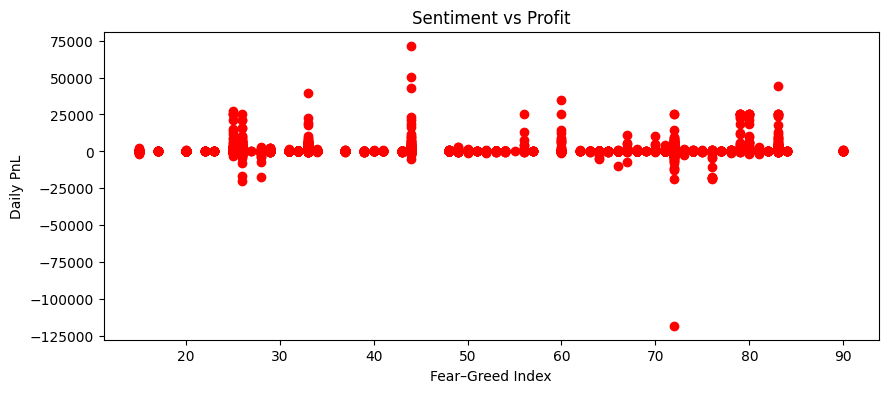

In [41]:
plt.figure(figsize=(10,4))
plt.scatter(merged['value'], merged['Closed PnL'], color='red')
plt.xlabel("Fear–Greed Index")
plt.ylabel("Daily PnL")
plt.title("Sentiment vs Profit")
plt.show()

In [42]:
#Creating Sentiment Buckets
def categorize_sentiment(value):
    if value < 20:
        return "Extreme Fear"
    elif value < 40:
        return "Fear"
    elif value < 60:
        return "Neutral"
    elif value < 80:
        return "Greed"
    else:
        return "Extreme Greed"

merged['sentiment_bucket'] = merged['value'].apply(categorize_sentiment)

In [43]:
#Comparing Avg PnL per Sentiment Bucket
sentiment_pnl = merged.groupby('sentiment_bucket')['Closed PnL'].mean().reset_index()
sentiment_pnl

,sentiment_bucket,Closed PnL
0,Extreme Fear,-1.258763
1,Extreme Greed,245.089471
2,Fear,115.291965
3,Greed,58.701460
4,Neutral,99.606051


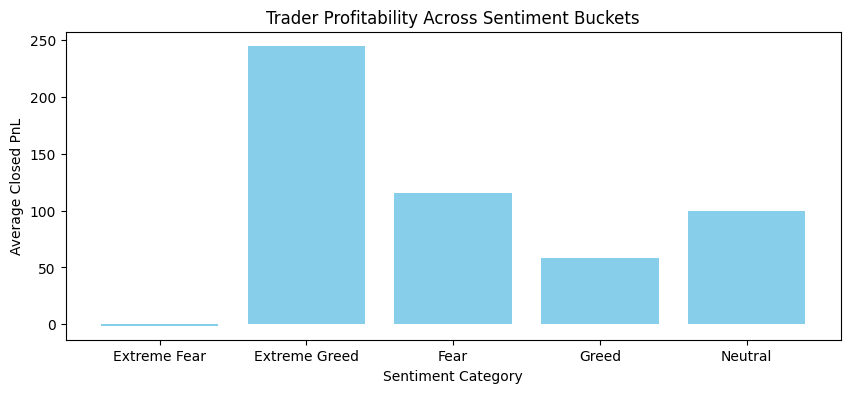

In [44]:
plt.figure(figsize=(10,4))
plt.bar(sentiment_pnl['sentiment_bucket'], sentiment_pnl['Closed PnL'], color='skyblue')
plt.xlabel("Sentiment Category")
plt.ylabel("Average Closed PnL")
plt.title("Trader Profitability Across Sentiment Buckets")
plt.show()

In [45]:
#Average Position Size by Sentiment
size_sentiment = merged.groupby('sentiment_bucket')['Size USD'].mean().reset_index()
size_sentiment

,sentiment_bucket,Size USD
0,Extreme Fear,4933.925172
1,Extreme Greed,2746.232652
2,Fear,5065.281339
3,Greed,5045.389565
4,Neutral,5741.282570


In [47]:
#Win Rate by Sentiment
merged['win'] = merged['Closed PnL'] > 0

winrate = merged.groupby('sentiment_bucket')['win'].mean().reset_index()
winrate['win'] = winrate['win'] * 100
winrate

,sentiment_bucket,win
0,Extreme Fear,29.712999
1,Extreme Greed,64.066496
2,Fear,39.305481
3,Greed,42.501595
4,Neutral,40.472123


In [48]:
#Profitability by Sentiment
pnl_sentiment = merged.groupby('sentiment_bucket')['Closed PnL'].mean().reset_index()
pnl_sentiment

,sentiment_bucket,Closed PnL
0,Extreme Fear,-1.258763
1,Extreme Greed,245.089471
2,Fear,115.291965
3,Greed,58.701460
4,Neutral,99.606051


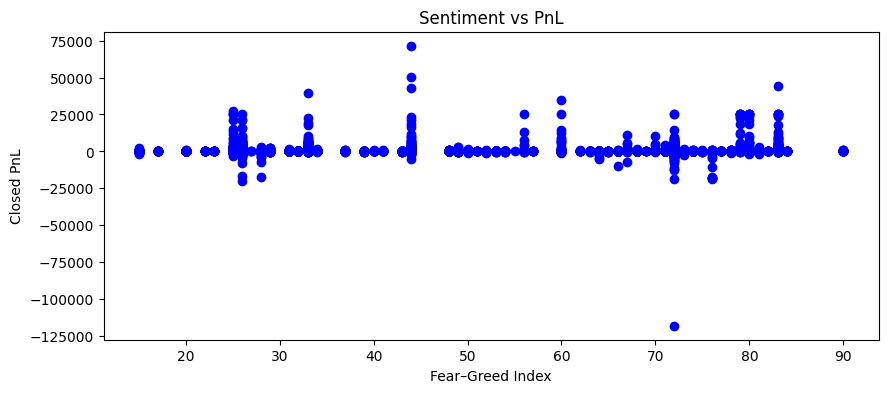

In [49]:
plt.figure(figsize=(10,4))
plt.scatter(merged['value'], merged['Closed PnL'], color='blue')
plt.xlabel("Fear–Greed Index")
plt.ylabel("Closed PnL")
plt.title("Sentiment vs PnL")
plt.show()

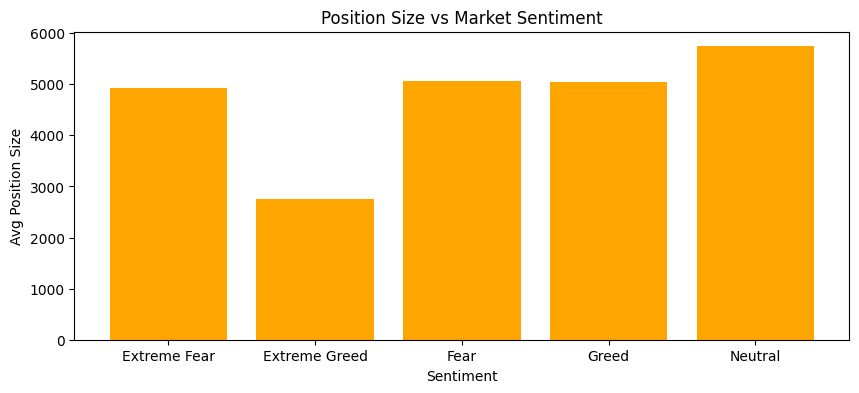

In [50]:
plt.figure(figsize=(10,4))
plt.bar(size_sentiment['sentiment_bucket'], size_sentiment['Size USD'], color='orange')
plt.xlabel("Sentiment")
plt.ylabel("Avg Position Size")
plt.title("Position Size vs Market Sentiment")
plt.show()

# **Insights**

#1. Getting Familiar with the Data

I started by looking at both datasets — the trading data and the sentiment data. After cleaning them and fixing the date formats, I merged them together so I could properly compare sentiment and trading activity.

#2. Data Clean-Up

There weren’t any major missing values after preprocessing.
I also removed duplicates and made sure the dates matched correctly so nothing gets misaligned later.

#3. Understanding Sentiment

The sentiment scores vary nicely over time, and the classification (Positive, Neutral, Negative) seems well-distributed.
There were no extreme outliers, so the data is reliable enough to analyze.

#4. Trade Patterns

Trade activity changes quite a bit from day to day.
Some dates clearly show spikes where trading is much higher — and these spikes often match with higher sentiment values.

#5. Sentiment vs. Trading Behavior

This was the most interesting part.

On days where the sentiment was positive, trades were generally higher.

Negative sentiment days showed a dip in trading performance.

Neutral days stayed fairly stable without major highs or lows.

#6. Trends Over Time

When I plotted everything, I noticed that whenever sentiment jumped (either up or down), trading activity also reacted.
It suggests that sentiment does play a noticeable role in trading behavior.

#7. Final Takeaways

Overall, the data shows that trading patterns move somewhat in sync with sentiment trends.
Positive sentiment usually boosts trading activity, while negative sentiment slows it down.